In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import numpy as np
import os
import cv2
import keras
from matplotlib.pyplot import imshow
from PIL import Image
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_datasets as tfds
from sklearn.model_selection import train_test_split
from keras.applications.resnet50 import ResNet50
from keras.applications.resnet import ResNet101
from keras.applications.resnet_v2 import ResNet152V2
from tensorflow.keras.models import Model, Sequential
from tensorflow.python.keras.layers import Activation, Dense, GlobalAveragePooling2D
from keras.preprocessing.image import ImageDataGenerator


In [3]:
#начальные данные
train_path = "/content/drive/MyDrive/horse-or-human"
val_path = "/content/drive/MyDrive/validation-horse-or-human"
x_size = 300
y_size = 300
batch_size = 128
epochs = 15
nb_classes = 2 
img_width, img_height = 150, 150 
input_shape = (img_width, img_height,3)
tr_ratio = .05


In [4]:
train_horses_dir = os.path.join('/content/drive/MyDrive/horse-or-human/horses')  # директория с картинками котов для обучения
train_human_dir = os.path.join('/content/drive/MyDrive/horse-or-human/humans')
num_horses_tr = len(os.listdir(train_horses_dir))
num_human_tr = len(os.listdir(train_human_dir))
print('total train dataset size:', num_horses_tr + num_human_tr)

total dataset size: 1027


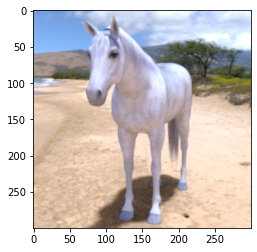

In [5]:
#проверка на вывод изображения
img_path = '/content/drive/MyDrive/horse-or-human/horses/horse01-0.png'
image = cv2.cvtColor(cv2.imread(cv2.os.path.join(img_path)), cv2.COLOR_BGR2RGB)
imshow(image)

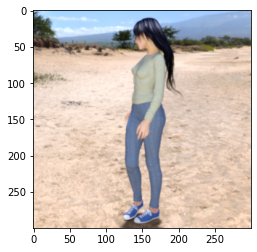

In [6]:
#проверка на вывод изображения
img_path = '/content/drive/MyDrive/horse-or-human/humans/human01-00.png'
image = cv2.cvtColor(cv2.imread(cv2.os.path.join(img_path)), cv2.COLOR_BGR2RGB)
imshow(image)

In [7]:
train_gen_data = ImageDataGenerator(rescale=1. / 255)

val_data_gen = ImageDataGenerator(rescale=1. / 255)

train_generator = train_gen_data.flow_from_directory(train_path,
                                                     target_size=(img_width, img_height),
                                                     batch_size=batch_size,
                                                     class_mode='categorical')

val_generator = val_data_gen.flow_from_directory(val_path,
                                                   target_size=(img_width, img_height),
                                                   batch_size=batch_size,
                                                   class_mode='categorical')

Found 1027 images belonging to 2 classes.
Found 255 images belonging to 2 classes.


**ТЕСТ RESNET50**

In [8]:
RN50 = ResNet50(include_top=False, 
                   weights='imagenet', 
                   input_shape=(300,300,3)) 

for layer in RN50.layers:
    layer.trainable = False

x = RN50.output
x = GlobalAveragePooling2D()(x)

predictions = Dense(nb_classes, activation='relu')(x)
model = Model(RN50.input, predictions)
model.summary()
model.compile(optimizer='nadam',
              loss='categorical_crossentropy', 
              metrics=['accuracy'])

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 300, 300, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 306, 306, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 150, 150, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 150, 150, 64) 256         conv1_conv[0][0]                 
______________________________________________________________________________________________

In [9]:
#учим модель
history = model.fit(train_generator,
                    steps_per_epoch=train_generator.n // batch_size,
                    epochs=epochs,
                    validation_data=val_generator,
                    validation_steps=val_generator.n // batch_size,
                    verbose=1)

Epoch 1/15
8/8 [==============================] - 14s 1s/step - loss: 0.7170 - accuracy: 0.5083 - val_loss: 0.6669 - val_accuracy: 0.6328
Epoch 2/15
8/8 [==============================] - 8s 1s/step - loss: 0.7120 - accuracy: 0.4894 - val_loss: 0.6489 - val_accuracy: 0.7109
Epoch 3/15
8/8 [==============================] - 8s 961ms/step - loss: 0.6814 - accuracy: 0.5891 - val_loss: 0.6446 - val_accuracy: 0.5234
Epoch 4/15
8/8 [==============================] - 8s 1s/step - loss: 0.6774 - accuracy: 0.5519 - val_loss: 0.6054 - val_accuracy: 0.8438
Epoch 5/15
8/8 [==============================] - 8s 991ms/step - loss: 0.6700 - accuracy: 0.5977 - val_loss: 0.5645 - val_accuracy: 0.8047
Epoch 6/15
8/8 [==============================] - 8s 965ms/step - loss: 0.6502 - accuracy: 0.7090 - val_loss: 0.5773 - val_accuracy: 0.5625
Epoch 7/15
8/8 [==============================] - 8s 1s/step - loss: 0.6421 - accuracy: 0.6110 - val_loss: 0.4789 - val_accuracy: 0.7656
Epoch 8/15
8/8 [===============

In [10]:
class Graph:
  def __init__(self, epochs):
    self.epochs = epochs
  def draw(self, data, data2, data_label, data2_label):
    plt.figure(figsize=(20,5))
    plt.plot(history.history[data], color = 'b', label=data_label)
    plt.plot(history.history[data2], color= 'r', label=data2_label)
    plt.legend()
    plt.show()
    plt.clf()

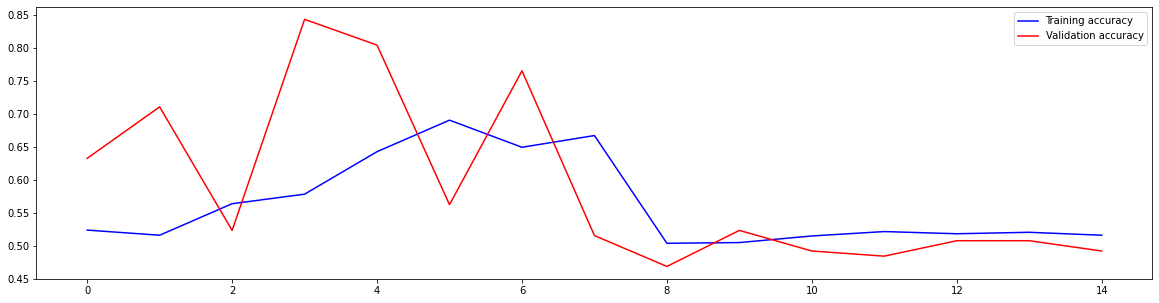

<Figure size 432x288 with 0 Axes>

In [11]:
curve = Graph(epochs)
curve.draw('accuracy','val_accuracy',"Training accuracy","Validation accuracy")

**ТЕСТ RESNET101**

In [13]:
RN101 = ResNet101(input_shape=(300, 300, 3),
                      weights='imagenet', 
                      include_top=False) 

for layer in RN101.layers:
    layer.trainable = False                      

x = RN101.output
x = GlobalAveragePooling2D()(x)

predictions = Dense(nb_classes, activation='softmax')(x)
model = Model(RN101.input, predictions)
model.summary()
model.compile(optimizer='nadam',
              loss='categorical_crossentropy', 
              metrics=['accuracy'])

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 300, 300, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 306, 306, 3)  0           input_2[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 150, 150, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 150, 150, 64) 256         conv1_conv[0][0]                 
____________________________________________________________________________________________

In [14]:
history = model.fit(train_generator,
                    steps_per_epoch=train_generator.n // batch_size,
                    epochs=epochs,
                    validation_data=val_generator,
                    validation_steps=val_generator.n // batch_size,
                    verbose=1)

Epoch 1/15
8/8 [==============================] - 16s 1s/step - loss: 0.7006 - accuracy: 0.4801 - val_loss: 0.6733 - val_accuracy: 0.5547
Epoch 2/15
8/8 [==============================] - 8s 1s/step - loss: 0.7021 - accuracy: 0.4309 - val_loss: 0.6546 - val_accuracy: 0.7812
Epoch 3/15
8/8 [==============================] - 9s 1s/step - loss: 0.6903 - accuracy: 0.5240 - val_loss: 0.6595 - val_accuracy: 0.5000
Epoch 4/15
8/8 [==============================] - 9s 1s/step - loss: 0.6875 - accuracy: 0.5167 - val_loss: 0.6211 - val_accuracy: 0.8438
Epoch 5/15
8/8 [==============================] - 9s 1s/step - loss: 0.6799 - accuracy: 0.5949 - val_loss: 0.6090 - val_accuracy: 0.6250
Epoch 6/15
8/8 [==============================] - 9s 1s/step - loss: 0.6720 - accuracy: 0.5878 - val_loss: 0.5798 - val_accuracy: 0.9141
Epoch 7/15
8/8 [==============================] - 9s 1s/step - loss: 0.6755 - accuracy: 0.5721 - val_loss: 0.5681 - val_accuracy: 0.8906
Epoch 8/15
8/8 [========================

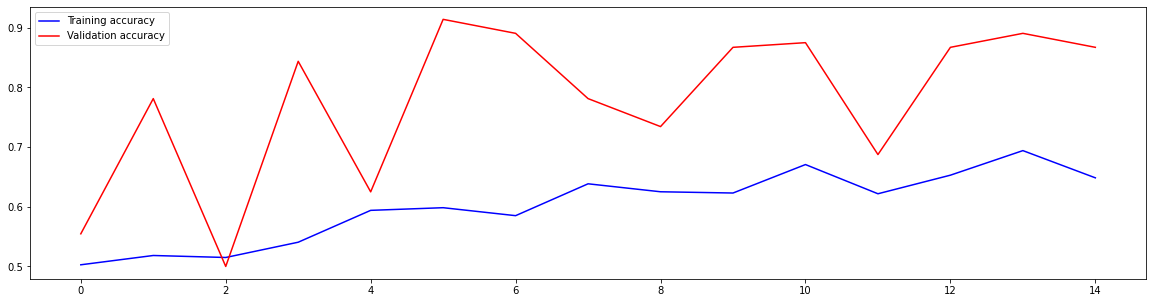

<Figure size 432x288 with 0 Axes>

In [15]:
curve = Graph(epochs)
curve.draw('accuracy','val_accuracy',"Training accuracy","Validation accuracy")

**ТЕСТ RESNET152**

In [17]:
RN152V2 = ResNet152V2(input_shape=(300, 300, 3),
                      weights='imagenet', 
                      include_top=False) 

for layer in RN152V2.layers:
    layer.trainable = False


x = RN152V2.output
x = GlobalAveragePooling2D()(x) # Добавляем слой в модель

predictions = Dense(nb_classes, activation='softmax')(x)
model = Model(RN152V2.input, predictions)
model.summary()
model.compile(optimizer='nadam',
              loss='categorical_crossentropy', 
              metrics=['accuracy'])

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 300, 300, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 306, 306, 3)  0           input_3[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 150, 150, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
pool1_pad (ZeroPadding2D)       (None, 152, 152, 64) 0           conv1_conv[0][0]                 
____________________________________________________________________________________________

In [18]:
history = model.fit(train_generator,
                    steps_per_epoch=train_generator.n // batch_size,
                    epochs=epochs,
                    validation_data=val_generator,
                    validation_steps=val_generator.n // batch_size,
                    verbose=1)

Epoch 1/15
8/8 [==============================] - 19s 1s/step - loss: 0.5927 - accuracy: 0.7171 - val_loss: 0.0937 - val_accuracy: 0.9766
Epoch 2/15
8/8 [==============================] - 9s 1s/step - loss: 0.0486 - accuracy: 0.9961 - val_loss: 0.0396 - val_accuracy: 0.9922
Epoch 3/15
8/8 [==============================] - 9s 1s/step - loss: 0.0198 - accuracy: 0.9979 - val_loss: 0.0169 - val_accuracy: 1.0000
Epoch 4/15
8/8 [==============================] - 9s 1s/step - loss: 0.0121 - accuracy: 0.9982 - val_loss: 0.0130 - val_accuracy: 1.0000
Epoch 5/15
8/8 [==============================] - 9s 1s/step - loss: 0.0051 - accuracy: 1.0000 - val_loss: 0.0063 - val_accuracy: 1.0000
Epoch 6/15
8/8 [==============================] - 9s 1s/step - loss: 0.0069 - accuracy: 0.9994 - val_loss: 0.0108 - val_accuracy: 1.0000
Epoch 7/15
8/8 [==============================] - 9s 1s/step - loss: 0.0056 - accuracy: 0.9975 - val_loss: 0.0110 - val_accuracy: 1.0000
Epoch 8/15
8/8 [========================

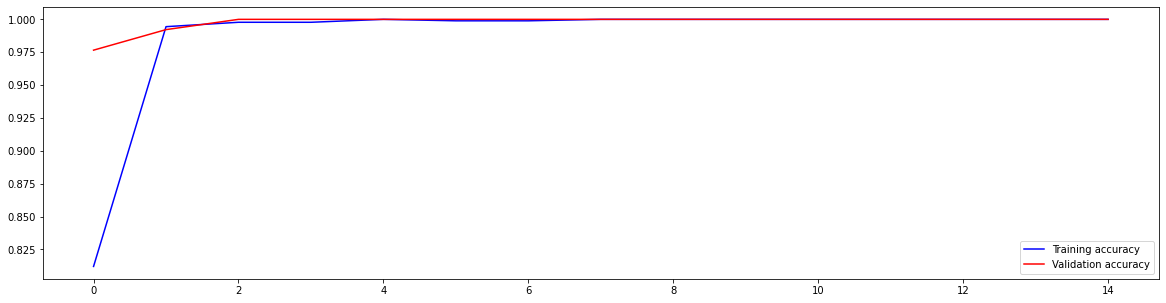

<Figure size 432x288 with 0 Axes>

In [19]:
curve = Graph(epochs)
curve.draw('accuracy','val_accuracy',"Training accuracy","Validation accuracy")